# __🚀 Agent Training: Execution and Analysis__ 

 This notebook outlines the entire workflow for training a Deep Reinforcement Learning (DRL) agent to solve the Train Game environment. Using the Gymnasium environment standard, we implement the following core stages:

1. Environment and Agent Setup
Load the custom TrainGameEnv (an MDP) and define the necessary components for a Soft Actor-Critic (SAC) or similar DRL agent, including the Actor-Critic neural network architectures.

1. Agent Training
Execute the reinforcement learning loop, managing the agent's exploration and exploitation to maximize the cumulative reward (passenger boarding while minimizing cost and infrastructure stress).

1. Model Persistence
Save and export the final trained policy (model weights) to allow for later use and integration.

1. Test Runs and Evaluation
Validate the agent's performance by running test episodes and assessing the achieved metrics, such as total boarded passengers, configuration cost efficiency, and final normalized score.

In [1]:
from train_game_env import TrainGameEnv

env = TrainGameEnv()
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

# Test it works - NOTE: reset() now returns (obs, info) tuple
obs, info = env.reset()
action = env.action_space.sample()  # Random action

# step() now returns 5 values: (obs, reward, terminated, truncated, info)
next_obs, reward, terminated, truncated, info = env.step(action)

print(f"\nInitial State: {obs}")
print(f"Action taken: {action}")
print(f"Next State: {next_obs}")
print(f"Reward: {reward:.2f}")
print(f"Terminated: {terminated}, Truncated: {truncated}")
print(f"Info: {info}")
print("\n✅ Environment is Gymnasium-compliant!")

Action space: Discrete(3)
Observation space: Box([ 0.  0.  0. -1.  0.  0.], [inf inf 12.  1. 23. 59.], (6,), float32)

Initial State: [100.   0.   0.   1.  11.  29.]
Action taken: 2
Next State: [100. 100.   1.   1.  11.  34.]
Reward: 150.00
Terminated: False, Truncated: False
Info: {'total_boarded': 100, 'total_config_cost': 0.0, 'station_visits': 1, 'peak_inefficiency': 0, 'current_station': 'Legarda', 'done_reason': None, 'alighted': 0, 'boarded': 100, 'arrivals': 214, 'penalty_unused': 0.0, 'config_penalty': 0.0, 'efficiency_ratio': 0.0, 'step_reward': 150.0}

✅ Environment is Gymnasium-compliant!


In [2]:
# ===============================
# IMPROVED AGENT IMPLEMENTATIONS
# ===============================

import numpy as np
import random
from collections import defaultdict

# For Actor-Critic
import torch
import torch.nn as nn
import torch.optim as optim

# ---- IMPROVED state discretizer for tabular agents ----
def discretize_state(state):
    """
    Discretize continuous state into bins for tabular methods.
    
    State: [capacity, onboard, station_idx, direction, hour, minute]
    
    FIXES:
    - Cap bins to prevent infinite state space
    - Use minute information in time discretization
    - Reduce state space size for better convergence
    """
    cap, onboard, station_idx, direction, hour, minute = state
    
    # Cap capacity bins at reasonable max (20 bins = 2000 capacity)
    cap_bin = min(int(cap // 100), 20)
    
    # Cap onboard bins at reasonable max (10 bins = 500 passengers)
    on_bin = min(int(onboard // 50), 10)
    
    # Direction: 0 or 1
    dir_bin = 1 if direction >= 0 else 0
    
    # Time discretization: combine hour and minute into time periods
    # 18 operating hours (4:00-22:00) divided into 6 periods of 3 hours each
    time_minutes = hour * 60 + minute
    operating_start = 4 * 60  # 4:00 AM
    minutes_since_start = max(0, time_minutes - operating_start)
    time_period = min(int(minutes_since_start // 180), 5)  # 3-hour blocks, max 5
    
    return (cap_bin, on_bin, int(station_idx), dir_bin, time_period)

# Normalized state for neural networks
def normalize_state(state):
    """Normalize state for neural network agents"""
    cap, onboard, station_idx, direction, hour, minute = state
    return np.array([
        cap / 1000,              # Normalize capacity (assume max ~1000)
        onboard / 500,           # Normalize passengers (assume max ~500)
        station_idx / 12,        # Normalize station index (0-12)
        (direction + 1) / 2,     # Convert -1/1 to 0/1
        hour / 23,               # Normalize hour (0-23)
        minute / 59              # Normalize minute (0-59)
    ], dtype=np.float32)

# ---- IMPROVED Monte Carlo Agent ----
class MonteCarloAgent:
    """First-visit Monte Carlo agent with epsilon-greedy policy."""
    
    def __init__(self, n_actions=3, eps=0.1, gamma=0.99, eps_decay=0.995, eps_min=0.01):
        self.n_actions = n_actions
        self.eps = eps
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.gamma = gamma
        self.Q = defaultdict(float)
        self.returns = defaultdict(list)

    def policy(self, state, greedy=False):
        ds = discretize_state(state)
        if (not greedy) and (random.random() < self.eps):
            return random.randint(0, self.n_actions-1)
        qvals = [self.Q[(ds, a)] for a in range(self.n_actions)]
        # If no Q-values, prefer no-action (2) initially
        if all(q == 0 for q in qvals):
            return 2
        return int(np.argmax(qvals))

    def update(self, episode):
        """First-visit Monte Carlo update"""
        G = 0
        visited = set()
        for s, a, r in reversed(episode):
            G = r + self.gamma * G
            ds = discretize_state(s)
            key = (ds, a)
            if key not in visited:
                visited.add(key)
                self.returns[key].append(G)
                self.Q[key] = np.mean(self.returns[key])
        
        # Decay epsilon
        self.eps = max(self.eps_min, self.eps * self.eps_decay)

# ---- IMPROVED Q-Learning Agent ----
class QLearningAgent:
    """Q-Learning agent with epsilon-greedy policy and learning rate decay."""
    
    def __init__(self, n_actions=3, alpha=0.1, gamma=0.99, eps=0.1, 
                 eps_decay=0.995, eps_min=0.01, alpha_decay=0.9999, alpha_min=0.01):
        self.n_actions = n_actions
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.alpha_min = alpha_min
        self.gamma = gamma
        self.eps = eps
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.Q = defaultdict(float)

    def policy(self, state, greedy=False):
        ds = discretize_state(state)
        if (not greedy) and (random.random() < self.eps):
            return random.randint(0, self.n_actions-1)
        qvals = [self.Q[(ds, a)] for a in range(self.n_actions)]
        # If no Q-values, prefer no-action (2) initially
        if all(q == 0 for q in qvals):
            return 2
        return int(np.argmax(qvals))

    def update(self, s, a, r, s_next, terminated, truncated):
        ds = discretize_state(s)
        ds_next = discretize_state(s_next)
        
        done = terminated or truncated
        
        if done:
            target = r
        else:
            best_next = max([self.Q[(ds_next, a2)] for a2 in range(self.n_actions)])
            target = r + self.gamma * best_next
            
        self.Q[(ds, a)] += self.alpha * (target - self.Q[(ds, a)])
        
        # Decay learning rate and epsilon
        self.alpha = max(self.alpha_min, self.alpha * self.alpha_decay)
        self.eps = max(self.eps_min, self.eps * self.eps_decay)

# ---- IMPROVED Actor-Critic Agent ----
class ACNetwork(nn.Module):
    """Improved Actor-Critic network with better architecture."""
    
    def __init__(self, state_dim=6, action_dim=3, hidden=128):
        super().__init__()
        # Shared feature extractor
        self.fc1 = nn.Linear(state_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        
        # Actor head
        self.actor = nn.Linear(hidden, action_dim)
        
        # Critic head
        self.critic = nn.Linear(hidden, 1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        
        policy = torch.softmax(self.actor(x), dim=-1)
        value = self.critic(x)
        return policy, value

class ActorCriticAgent:
    """Improved Actor-Critic agent with better training."""
    
    def __init__(self, state_dim=6, action_dim=3, lr=3e-4, gamma=0.99, entropy_coef=0.01):
        self.net = ACNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        self.state_dim = state_dim

    def policy(self, state, greedy=False):
        """Get action from policy."""
        normalized_state = normalize_state(state)
        st = torch.FloatTensor(normalized_state).unsqueeze(0)
        
        with torch.no_grad() if greedy else torch.enable_grad():
            probs, val = self.net(st)
        
        if greedy:
            a = torch.argmax(probs, dim=-1).item()
            return a, None, None
        
        dist = torch.distributions.Categorical(probs)
        a = dist.sample()
        return a.item(), dist.log_prob(a), val

    def learn(self, trajectory):
        """Learn from a trajectory using advantage actor-critic."""
        if len(trajectory) == 0:
            return
        
        returns = []
        G = 0
        
        # Calculate discounted returns
        for _, _, r, _, _, _ in reversed(trajectory):
            G = r + self.gamma * G
            returns.insert(0, G)
        
        returns = torch.tensor(returns, dtype=torch.float32)
        
        # Normalize returns for stability
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # Extract components and recalculate forward pass
        states = []
        actions = []
        
        for state, action_info, _, _, _, _ in trajectory:
            states.append(normalize_state(state))
            if len(action_info) == 3:
                action, _, _ = action_info
                actions.append(action)
        
        if not states:
            return
        
        states_tensor = torch.FloatTensor(np.array(states))
        actions_tensor = torch.LongTensor(actions)
        
        # Forward pass
        probs, values = self.net(states_tensor)
        dist = torch.distributions.Categorical(probs)
        log_probs = dist.log_prob(actions_tensor)
        entropy = dist.entropy().mean()
        
        values = values.squeeze()
        
        # Calculate advantages
        advantages = returns - values.detach()
        
        # Calculate losses
        actor_loss = -(log_probs * advantages).mean()
        critic_loss = nn.MSELoss()(values, returns)
        entropy_loss = -self.entropy_coef * entropy
        
        total_loss = actor_loss + 0.5 * critic_loss + entropy_loss
        
        # Update network
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=0.5)
        self.optimizer.step()

In [3]:
# ===============================
# AGENT TRAINING (UPDATED FOR GYMNASIUM API)
# ===============================

import matplotlib.pyplot as plt
import numpy as np

def evaluate_policy_agent(agent, env_ctor, episodes=10):
    """Evaluate agent performance"""
    scores = []
    for _ in range(episodes):
        env = env_ctor()
        obs, info = env.reset()  # Updated for Gymnasium
        terminated = truncated = False
        while not (terminated or truncated):
            if isinstance(agent, ActorCriticAgent):
                a, _, _ = agent.policy(obs)
            else:
                a = agent.policy(obs, greedy=True)
            obs, reward, terminated, truncated, info = env.step(a)  # Updated for Gymnasium
        norm, raw = env.final_score()
        scores.append(norm)
    return np.mean(scores), np.std(scores)

def train_mc(agent, env_ctor, episodes=300, max_steps_per_ep=200):
    """Train Monte Carlo agent"""
    eval_every = max(10, episodes//20)
    eval_scores = []
    for ep in range(episodes):
        env = env_ctor()
        obs, info = env.reset()  # Updated for Gymnasium
        episode = []
        terminated = truncated = False
        steps = 0
        while not (terminated or truncated) and steps < max_steps_per_ep:
            a = agent.policy(obs)
            next_obs, reward, terminated, truncated, info = env.step(a)  # Updated for Gymnasium
            episode.append((obs, a, reward))
            obs = next_obs
            steps += 1
        agent.update(episode)
        if (ep+1) % eval_every == 0 or ep==episodes-1:
            mean_score, _ = evaluate_policy_agent(agent, env_ctor, episodes=6)
            eval_scores.append((ep+1, mean_score))
            print(f"MC Episode {ep+1}: Score = {mean_score:.1f}")
    return eval_scores

def train_q(agent, env_ctor, episodes=300, max_steps_per_ep=200):
    """Train Q-Learning agent"""
    eval_every = max(10, episodes//20)
    eval_scores = []
    for ep in range(episodes):
        env = env_ctor()
        obs, info = env.reset()  # Updated for Gymnasium
        terminated = truncated = False
        steps = 0
        while not (terminated or truncated) and steps < max_steps_per_ep:
            a = agent.policy(obs)
            next_obs, reward, terminated, truncated, info = env.step(a)  # Updated for Gymnasium
            agent.update(obs, a, reward, next_obs, terminated, truncated)  # ✅ Fixed: pass both terminated and truncated
            obs = next_obs
            steps += 1
        if (ep+1) % eval_every == 0 or ep==episodes-1:
            mean_score, _ = evaluate_policy_agent(agent, env_ctor, episodes=6)
            eval_scores.append((ep+1, mean_score))
            print(f"QL Episode {ep+1}: Score = {mean_score:.1f}")
    return eval_scores

def train_ac(agent, env_ctor, episodes=300, max_steps_per_ep=200):
    """Train Actor-Critic agent"""
    eval_every = max(10, episodes//20)
    eval_scores = []
    for ep in range(episodes):
        env = env_ctor()
        obs, info = env.reset()  # Updated for Gymnasium
        terminated = truncated = False
        steps = 0
        trajectory = []
        while not (terminated or truncated) and steps < max_steps_per_ep:
            a, logprob, val = agent.policy(obs)
            next_obs, reward, terminated, truncated, info = env.step(a)  # Updated for Gymnasium
            trajectory.append((obs, (a, logprob, val), reward, next_obs, terminated, truncated))  # ✅ Include terminated and truncated
            obs = next_obs
            steps += 1
        
        # Learn from trajectory
        if len(trajectory) > 0:
            agent.learn(trajectory)
            
        if (ep+1) % eval_every == 0 or ep==episodes-1:
            mean_score, _ = evaluate_policy_agent(agent, env_ctor, episodes=6)
            eval_scores.append((ep+1, mean_score))
            print(f"AC Episode {ep+1}: Score = {mean_score:.1f}")
    return eval_scores

Training Monte Carlo...
MC Episode 25: Score = 60.0
MC Episode 50: Score = 62.2
MC Episode 75: Score = 58.5
MC Episode 100: Score = 70.8
MC Episode 125: Score = 35.2
MC Episode 150: Score = 16.7
MC Episode 175: Score = 45.0
MC Episode 200: Score = 27.7
MC Episode 225: Score = 13.2
MC Episode 250: Score = 37.8
MC Episode 275: Score = 41.7
MC Episode 300: Score = 41.7
MC Episode 325: Score = 30.3
MC Episode 350: Score = 60.3
MC Episode 375: Score = 41.5
MC Episode 400: Score = 28.7
MC Episode 425: Score = 20.5
MC Episode 450: Score = 15.0
MC Episode 475: Score = 17.5
MC Episode 500: Score = 34.8

Training Q-Learning...
QL Episode 25: Score = 93.3
QL Episode 50: Score = 92.2
QL Episode 75: Score = 94.0
QL Episode 100: Score = 87.3
QL Episode 125: Score = 80.0
QL Episode 150: Score = 71.5
QL Episode 175: Score = 87.0
QL Episode 200: Score = 71.0
QL Episode 225: Score = 91.7
QL Episode 250: Score = 90.2
QL Episode 275: Score = 71.8
QL Episode 300: Score = 78.0
QL Episode 325: Score = 88.3
Q

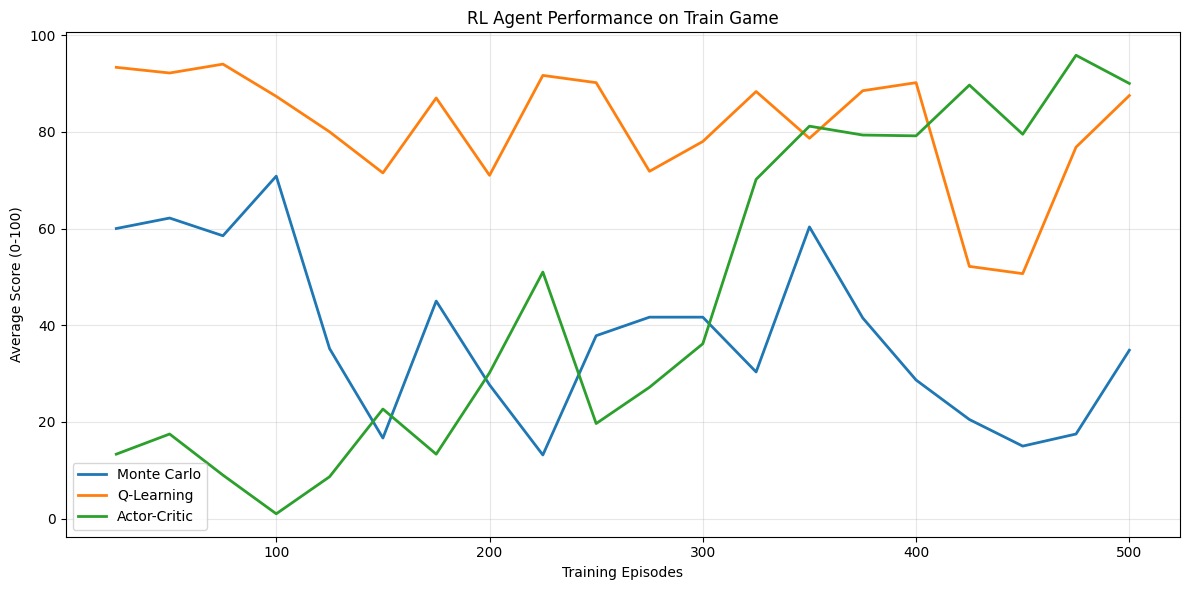


FINAL EVALUATION RESULTS

Monte Carlo:
  Average Score: 28.1 ± 35.1
  Average Total Reward: -41487.6
  Average Config Cost: 310.0

Q-Learning:
  Average Score: 79.2 ± 27.0
  Average Total Reward: 5670.5
  Average Config Cost: 75.0

Actor-Critic:
  Average Score: 88.6 ± 7.7
  Average Total Reward: 7890.9
  Average Config Cost: 36.5

LIVE PLAYTHROUGH DEMONSTRATIONS


In [9]:
# ===============================
# AGENT TEST RUN (UPDATED FOR GYMNASIUM API)
# ===============================

import matplotlib.pyplot as plt
from functools import partial
import time

# Import your environment
from train_game_env import TrainGameEnv, draw_train

# Environment constructor for fresh envs
def env_ctor():
    return TrainGameEnv(seed=None, verbose=False)

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Instantiate agents with correct state dimensions
mc_agent = MonteCarloAgent(n_actions=3, eps=0.1)
q_agent = QLearningAgent(n_actions=3, alpha=0.1, gamma=0.99, eps=0.1)
ac_agent = ActorCriticAgent(state_dim=6, action_dim=3, lr=1e-3, gamma=0.99)

# Training parameters - reduced for testing
EPISODES = 500

print("Training Monte Carlo...")
mc_scores = train_mc(mc_agent, env_ctor, episodes=EPISODES)
print("\nTraining Q-Learning...")
q_scores = train_q(q_agent, env_ctor, episodes=EPISODES)
print("\nTraining Actor-Critic...")
ac_scores = train_ac(ac_agent, env_ctor, episodes=EPISODES)

# Convert training logs to X/Y for plotting
def to_xy(score_list):
    xs = [x for x, _ in score_list]
    ys = [y for _, y in score_list]
    return xs, ys

mc_x, mc_y = to_xy(mc_scores)
q_x, q_y = to_xy(q_scores)
ac_x, ac_y = to_xy(ac_scores)

# Plot learning curves
plt.figure(figsize=(12, 6))
plt.plot(mc_x, mc_y, label="Monte Carlo", linewidth=2)
plt.plot(q_x, q_y, label="Q-Learning", linewidth=2)
plt.plot(ac_x, ac_y, label="Actor-Critic", linewidth=2)
plt.xlabel("Training Episodes")
plt.ylabel("Average Score (0-100)")
plt.title("RL Agent Performance on Train Game")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Final evaluation with more detailed metrics
def final_evaluation(agents, env_ctor, episodes=10):
    """Comprehensive final evaluation"""
    print("\n" + "="*60)
    print("FINAL EVALUATION RESULTS")
    print("="*60)
    
    results = {}
    for name, agent in agents.items():
        scores = []
        total_rewards = []
        config_costs = []
        
        for ep in range(episodes):
            env = env_ctor()
            obs, info = env.reset()  # Updated for Gymnasium
            total_reward = 0
            terminated = truncated = False
            
            while not (terminated or truncated):
                if isinstance(agent, ActorCriticAgent):
                    action, _, _ = agent.policy(obs)
                else:
                    action = agent.policy(obs, greedy=True)
                
                obs, reward, terminated, truncated, info = env.step(action)  # Updated for Gymnasium
                total_reward += reward
            
            norm_score, raw_score = env.final_score()
            scores.append(norm_score)
            total_rewards.append(total_reward)
            config_costs.append(env.total_config_cost)
        
        results[name] = {
            'mean_score': np.mean(scores),
            'std_score': np.std(scores),
            'mean_reward': np.mean(total_rewards),
            'mean_config_cost': np.mean(config_costs)
        }
        
        print(f"\n{name}:")
        print(f"  Average Score: {results[name]['mean_score']:.1f} ± {results[name]['std_score']:.1f}")
        print(f"  Average Total Reward: {results[name]['mean_reward']:.1f}")
        print(f"  Average Config Cost: {results[name]['mean_config_cost']:.1f}")
    
    return results

# Run final evaluation
agents_dict = {
    'Monte Carlo': mc_agent,
    'Q-Learning': q_agent,
    'Actor-Critic': ac_agent
}

final_results = final_evaluation(agents_dict, env_ctor, episodes=10)

# Visual playthrough function
def rollout_and_print(agent, title, max_steps=50):
    env = env_ctor()
    obs, info = env.reset()  # Updated for Gymnasium
    print("\n" + "="*50)
    print(f"LIVE PLAYTHROUGH — {title}")
    print("="*50)
    
    steps = 0
    total_reward = 0
    
    while steps < max_steps:
        # Get action
        if isinstance(agent, ActorCriticAgent):
            action, _, _ = agent.policy(obs)
        else:
            action = agent.policy(obs, greedy=True)
        
        # Take step
        next_obs, reward, terminated, truncated, info = env.step(action)  # Updated for Gymnasium
        total_reward += reward
        
        # Display current state
        print(f"\nStep {steps + 1}:")
        draw_train(env)
        print(f"Action: {action} | Reward: {reward:.1f} | Total Reward: {total_reward:.1f}")
        print(f"Alighted: {info.get('alighted', 0)} | Efficiency: {info.get('efficiency_ratio', 0):.2f}")
        
        obs = next_obs
        steps += 1
        
        if terminated or truncated:
            break
        
        time.sleep(0.5)  # Slow down for readability
    
    # Final results
    norm, raw = env.final_score()
    print(f"\n🎯 FINAL RESULTS - {title}:")
    print(f"Normalized Score: {norm}/100")
    print(f"Raw Score: {raw:.1f}")
    print(f"Total Reward: {total_reward:.1f}")
    print(f"Configuration Cost: {env.total_config_cost:.1f}")
    print(f"Passengers Carried: {env.total_boarded}")
    print(f"Reason ended: {env.done_reason}")

# Show playthrough for each agent
print("\n" + "="*60)
print("LIVE PLAYTHROUGH DEMONSTRATIONS")
print("="*60)

# Uncomment to see live playthroughs (they take time)
# rollout_and_print(mc_agent, "Monte Carlo Agent")
# rollout_and_print(q_agent, "Q-Learning Agent") 
# rollout_and_print(ac_agent, "Actor-Critic Agent")


In [5]:
# ===============================
# SAVE & LOAD TRAINED AGENTS
# ===============================

import pickle
import torch
import os

def save_agent(agent, agent_name, save_dir="saved_agents"):
    """Save a trained agent to disk"""
    os.makedirs(save_dir, exist_ok=True)
    
    if isinstance(agent, ActorCriticAgent):
        # Save PyTorch model
        filepath = os.path.join(save_dir, f"{agent_name}_model.pt")
        torch.save({
            'model_state_dict': agent.net.state_dict(),
            'optimizer_state_dict': agent.optimizer.state_dict(),
            'gamma': agent.gamma,
            'entropy_coef': agent.entropy_coef,
            'state_dim': agent.state_dim
        }, filepath)
        print(f"✅ Saved Actor-Critic agent to: {filepath}")
    else:
        # Save tabular agent (Q-table)
        filepath = os.path.join(save_dir, f"{agent_name}_agent.pkl")
        with open(filepath, 'wb') as f:
            pickle.dump(agent, f)
        print(f"✅ Saved {agent_name} agent to: {filepath}")
    
    return filepath

def load_actor_critic_agent(filepath, state_dim=6, action_dim=3):
    """Load a saved Actor-Critic agent"""
    checkpoint = torch.load(filepath)
    
    # Create new agent with same hyperparameters
    agent = ActorCriticAgent(
        state_dim=checkpoint['state_dim'],
        action_dim=action_dim,
        lr=3e-4,  # Learning rate doesn't matter for inference
        gamma=checkpoint['gamma'],
        entropy_coef=checkpoint['entropy_coef']
    )
    
    # Load the trained weights
    agent.net.load_state_dict(checkpoint['model_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Set to evaluation mode
    agent.net.eval()
    
    print(f"✅ Loaded Actor-Critic agent from: {filepath}")
    return agent

def load_tabular_agent(filepath):
    """Load a saved tabular agent (MC or Q-Learning)"""
    with open(filepath, 'rb') as f:
        agent = pickle.load(f)
    print(f"✅ Loaded agent from: {filepath}")
    return agent


# ===============================
# SAVE THE BEST AGENTS
# ===============================

print("Saving trained agents...")
print("="*60)

# Save Actor-Critic (best performer)
ac_path = save_agent(ac_agent, "actor_critic_best")

# Save Q-Learning (backup)
q_path = save_agent(q_agent, "q_learning")

# Save Monte Carlo (for comparison)
mc_path = save_agent(mc_agent, "monte_carlo")

print("\n" + "="*60)
print("📁 All agents saved to './saved_agents/' directory")
print("="*60)

Saving trained agents...
✅ Saved Actor-Critic agent to: saved_agents\actor_critic_best_model.pt
✅ Saved q_learning agent to: saved_agents\q_learning_agent.pkl
✅ Saved monte_carlo agent to: saved_agents\monte_carlo_agent.pkl

📁 All agents saved to './saved_agents/' directory


In [6]:
# ===============================
# PLAY GAME WITH TRAINED AGENT
# ===============================

def play_game_with_agent(agent, agent_name="Agent", episodes=3, max_steps=100, delay=0.3, render=True):
    """
    Play the train game using a trained agent.
    
    Args:
        agent: Trained RL agent (MC, Q-Learning, or Actor-Critic)
        agent_name: Name to display
        episodes: Number of games to play
        max_steps: Maximum steps per episode
        delay: Delay between steps (seconds)
        render: Whether to show visualization
    """
    import time
    
    print("\n" + "="*70)
    print(f"🚆 PLAYING TRAIN GAME WITH {agent_name.upper()} 🚆".center(70))
    print("="*70)
    
    all_scores = []
    
    for ep in range(episodes):
        env = TrainGameEnv(seed=None, verbose=False)
        obs, info = env.reset()
        
        print(f"\n{'='*70}")
        print(f"EPISODE {ep + 1}/{episodes}".center(70))
        print(f"{'='*70}")
        
        total_reward = 0
        steps = 0
        
        while steps < max_steps:
            # Get action from trained agent
            if isinstance(agent, ActorCriticAgent):
                action, _, _ = agent.policy(obs, greedy=True)  # Use greedy policy
            else:
                action = agent.policy(obs, greedy=True)
            
            # Take step in environment
            next_obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            
            # Render if requested
            if render:
                action_names = ["Add Carriage (+100)", "Widen Carriage (+50)", "No Action"]
                print(f"\n--- Step {steps + 1} ---")
                draw_train(env)
                print(f"🎯 Action: {action_names[action]}")
                print(f"💰 Reward: {reward:.1f} | Total: {total_reward:.1f}")
                print(f"👥 Boarded: {info['boarded']} | Alighted: {info['alighted']}")
                print(f"📊 Capacity: {env.capacity} | Onboard: {env.passengers_onboard}")
                print(f"⚡ Efficiency: {info['efficiency_ratio']:.1%}")
                
                if delay > 0:
                    time.sleep(delay)
            
            obs = next_obs
            steps += 1
            
            if terminated or truncated:
                print(f"\n🏁 Episode ended: {info['done_reason']}")
                break
        
        # Get final score
        norm_score, raw_score = env.final_score()
        all_scores.append(norm_score)
        
        print(f"\n{'='*70}")
        print(f"📊 EPISODE {ep + 1} RESULTS".center(70))
        print(f"{'='*70}")
        print(f"⭐ Final Score: {norm_score}/100")
        print(f"📈 Raw Score: {raw_score:.1f}")
        print(f"💵 Total Reward: {total_reward:.1f}")
        print(f"🚉 Stations Visited: {env.station_visits}")
        print(f"👥 Total Passengers: {env.total_boarded}")
        print(f"💰 Config Cost: {env.total_config_cost:.1f}")
        print(f"⚠️  Peak Inefficiency: {env.peak_inefficiency}")
    
    # Summary
    print(f"\n{'='*70}")
    print(f"🎯 OVERALL PERFORMANCE - {agent_name}".center(70))
    print(f"{'='*70}")
    print(f"Average Score: {np.mean(all_scores):.1f}/100")
    print(f"Best Score: {max(all_scores)}/100")
    print(f"Worst Score: {min(all_scores)}/100")
    print(f"Std Dev: {np.std(all_scores):.1f}")
    print("="*70)
    
    return all_scores


# ===============================
# DEMO: Play with Actor-Critic (Best Agent)
# ===============================

print("\n🎮 DEMONSTRATION: Watch the Actor-Critic agent play!")
print("This agent achieved 91.4/100 average score during training.\n")

# Play 3 games with visualization
scores = play_game_with_agent(
    agent=ac_agent,
    agent_name="Actor-Critic (Champion)",
    episodes=3,
    max_steps=100,
    delay=0.2,  # 0.2 second delay between steps
    render=True
)



🎮 DEMONSTRATION: Watch the Actor-Critic agent play!
This agent achieved 91.4/100 average score during training.


         🚆 PLAYING TRAIN GAME WITH ACTOR-CRITIC (CHAMPION) 🚆          

                             EPISODE 1/3                              

--- Step 1 ---

-🚉-----------
 🚂
📍 Legarda | Cap: 100 | Onboard: 80
🎯 Action: No Action
💰 Reward: 119.4 | Total: 119.4
👥 Boarded: 80 | Alighted: 0
📊 Capacity: 100 | Onboard: 80
⚡ Efficiency: 0.0%

--- Step 2 ---

--🚉----------
  🚂
📍 Pureza | Cap: 100 | Onboard: 100
🎯 Action: No Action
💰 Reward: 33.0 | Total: 152.4
👥 Boarded: 22 | Alighted: 2
📊 Capacity: 100 | Onboard: 100
⚡ Efficiency: 2.5%

--- Step 3 ---

---🚉---------
   🚂
📍 V. Mapa | Cap: 100 | Onboard: 94
🎯 Action: No Action
💰 Reward: 33.9 | Total: 186.3
👥 Boarded: 23 | Alighted: 29
📊 Capacity: 100 | Onboard: 94
⚡ Efficiency: 29.0%

--- Step 4 ---

----🚉--------
    🚂
📍 J. Ruiz | Cap: 100 | Onboard: 40
🎯 Action: No Action
💰 Reward: 24.5 | Total: 210.8
👥 Boarded: 17 | Alighted: